In [32]:
#Imports
# import os
# os.environ['NUMEXPR_MAX_THREADS'] = 40
import numpy as np
import random
from time import time
from tmu.models.classification.vanilla_classifier import TMClassifier
from scipy.sparse import lil_matrix
from skimage.util import view_as_windows
from sklearn.feature_extraction.text import CountVectorizer
import cv2
from skimage.transform import pyramid_gaussian, pyramid_laplacian, downscale_local_mean
import matplotlib.pyplot as plt #drawing plots
import matplotlib.patches as patches #drawing squares
from matplotlib.lines import Line2D
from scipy.ndimage import rotate
import math 


import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

from tqdm import tqdm #runtime stats

import ssl

ssl._create_default_https_context = ssl._create_unverified_context
from keras.datasets import cifar10


In [33]:
#Parameters

#TM
epochs = 5
max_included_literals = 500
clauses = 10
T = int((np.sqrt(clauses)/2 + 2)*10)
s = 1.5
step = 1
visual_tokens = True
encode_to_hypervec = False

#Data
#trained_labels = np.array([0,1,2,3])
trained_labels = np.arange(3)
training_pool_size = 1000 # number of testing pictures loaded

#preprocessing
resolution = 8 # scaled colors to thermometer code size of..
patch_dim = [3,3]

# Dice Dataset parameters
use_debug_dataset = True
train_size = training_pool_size
test_size = 300
window_top_left = (0, 0)
window_bottom_right = (32, 32)
dice_size = 12    

# Second run parameters


        

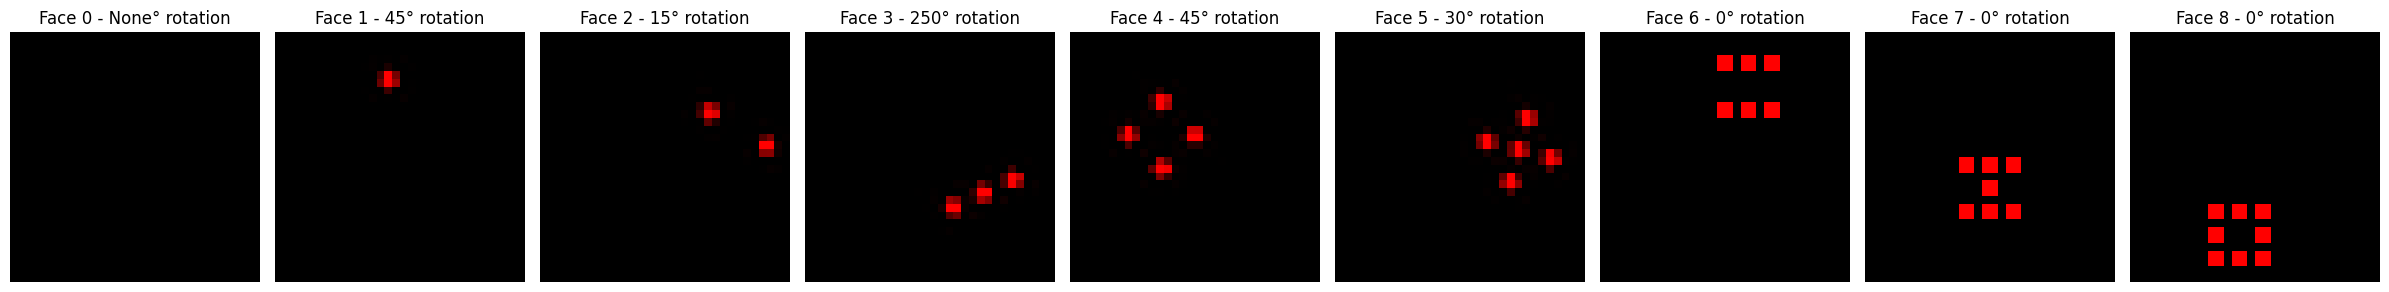

In [34]:
# Debug dataset creation function
def dice_image(value, top_left=(0, 0), bottom_right=(32, 32), dice_size=8, rand_placement=False, rotation_angle=None):
    img = np.zeros((32, 32, 3), dtype=np.uint8)
    
    # Relative dot size
    dot_size = dice_size // 6
    if dot_size<1:dot_size=1
    
    dot_color = (255, 0, 0)  # Red color
    
    if value not in range(0, 10):
        raise ValueError("Dice value should be between 0 and 10.")

    
    # Relative positions for the center of dice based on its value and dice size
    offset = dice_size // 4
    positions = {
        1: [(-offset, -offset)],
        2: [(-offset, -offset), (offset, offset)],
        3: [(-offset, -offset), (0, 0), (offset, offset)],
        4: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset)],
        5: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0)],
        6: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, -offset), (0, offset)],
        7: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0), (0, -offset), (0, offset)],
        8: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, -offset), (0, offset), (-offset, 0), (offset, 0)],
        9: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0), (0, -offset), (0, offset), (-offset, 0), (offset, 0)]
    }
    if rand_placement:
        # Generate a random position within the window for the center of the dice
        center_x = random.randint(top_left[0] + dice_size // 2, bottom_right[0] - dice_size // 2)
        center_y = random.randint(top_left[1] + dice_size // 2, bottom_right[1] - dice_size // 2)
    else:
        center_y = bottom_right[1] - top_left[1]
        center_x = bottom_right[0] - top_left[0]
    if value != 0:
        for pos in positions[value]:
            x = center_x + pos[0]
            y = center_y + pos[1]
            img[y-dot_size//2:y+dot_size//2, x-dot_size//2:x+dot_size//2] = dot_color

    # Rotation logic
    if rotation_angle is not None:
        if rotation_angle in [90, 180, 270]:
            img = np.rot90(img, k=rotation_angle // 90)
        else:
            img = rotate(img, rotation_angle, reshape=False, mode='nearest')

    return img


# Testing the function
# Plotting the dice faces with random positions and rotations within the specified window
window_top_left = (0, 0)
window_bottom_right = (32, 32)
dice_size = 12
fig, axes = plt.subplots(1, 9, figsize=(24, 4))

rotations = [None, 45, 15, 250, 45, 30, 0, 0, 0 ,0]  # Some sample rotations

for ax, value, rot in zip(axes, range(0, 11), rotations):
    ax.imshow(dice_image(value, window_top_left, window_bottom_right, dice_size, True, rot))
    ax.axis("off")
    ax.set_title(f"Face {value} - {rot}° rotation")

plt.tight_layout()
plt.show()

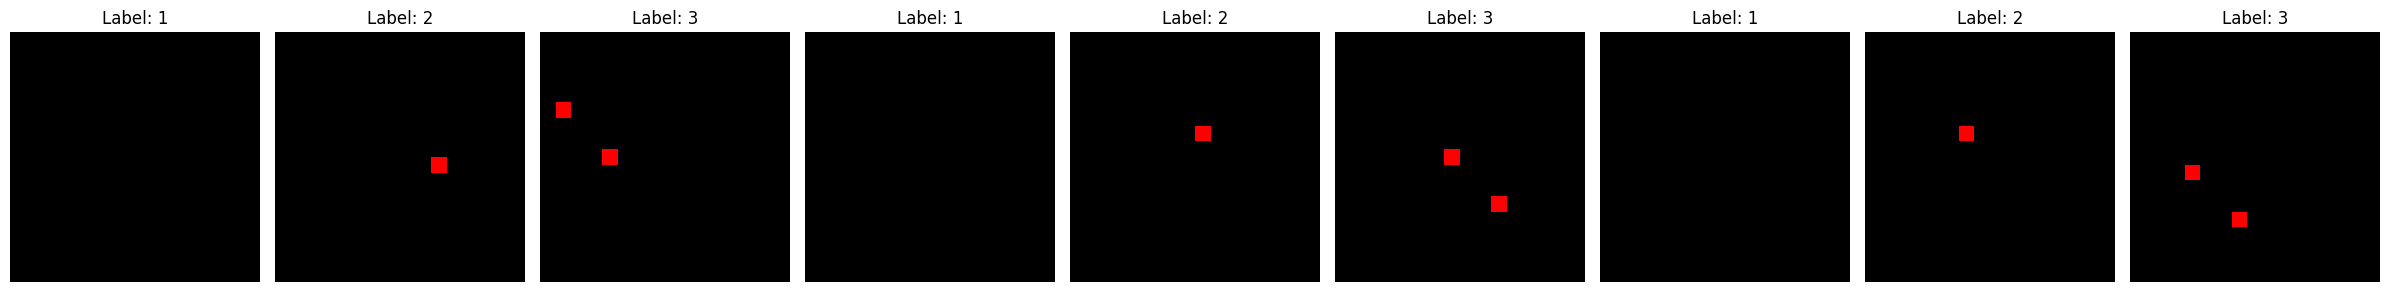

(1000, 32, 32, 3)
(1000,)
(300, 32, 32, 3)
(300,)


In [35]:
if use_debug_dataset: # Dataset selection
    def generate_debug_dataset(dataset_size, window_top_left, window_bottom_right, dice_size, random_rotations=False, include_random_class=False, random_placement=False):
        dataset = np.zeros((dataset_size, 32, 32, 3), dtype=np.uint8)
        labels = np.zeros((dataset_size,), dtype=np.uint8)
        
        #rotations = [None, 90, 180, 270]
        rotations = [None, 90, 180, 270]
        if not random_rotations:
            rotations = [None]
        
        for i in range(dataset_size):
            dice_val = trained_labels[(i % len(trained_labels))]
            rot = random.choice(rotations)
            # If the random class is to be included and the current index is for the random class
            if include_random_class and dice_val == 10:
                # Create a random pixel image
                dataset[i] = np.random.randint(0, 256, (32, 32, 3), dtype=np.uint8)
                labels[i] = 10  # The label for the random class
            else:
                # Create a dice image
                dataset[i] = dice_image(value=dice_val, top_left=window_top_left, bottom_right=window_bottom_right, dice_size=dice_size, rotation_angle=rot, rand_placement=random_placement)
                labels[i] = dice_val  # Making labels 0-indexed
        
        return dataset, labels

    

    # Generate datasets
    X_train_org, Y_train_org = generate_debug_dataset(train_size, window_top_left, window_bottom_right, dice_size, include_random_class=True, random_rotations=False, random_placement=True)
    X_test_org, Y_test_org = generate_debug_dataset(test_size, window_top_left, window_bottom_right, dice_size, random_rotations=False, random_placement=True)

    # Display some sample images from the training set
    fig, axes = plt.subplots(1, 9, figsize=(24, 4))
    for i in range(9):
        ax = axes[i]
        ax.imshow(X_train_org[i])
        ax.axis("off")
        ax.set_title(f"Label: {Y_train_org[i]+1}")

    plt.tight_layout()
    plt.show()
    labels = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
    
else:

    #Load cifar10
    (X_train_org, Y_train_org), (X_test_org, Y_test_org) = cifar10.load_data()
    labels = ["Airplane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]


    #adjust to train pool size
    X_test_org = X_test_org[0:training_pool_size]
    Y_test_org = Y_test_org.reshape(Y_test_org.shape[0])[0:training_pool_size]
    X_train_org = X_train_org[0:training_pool_size]
    Y_train_org = Y_train_org.reshape(Y_train_org.shape[0])[0:training_pool_size]

    #filter only desired labels
    X_train_org = X_train_org[np.in1d(Y_train_org, trained_labels)]
    Y_train_org = Y_train_org[np.in1d(Y_train_org, trained_labels)]

X_test_org = X_test_org[np.in1d(Y_test_org, trained_labels)]
Y_test_org = Y_test_org[np.in1d(Y_test_org, trained_labels)]

print(X_train_org.shape)
print(Y_train_org.shape)
print(X_test_org.shape)
print(Y_test_org.shape)



In [36]:
# Thermometer Coding
def thermometer_encode(image, resolution=8, prevMin=0, prevMax=255):
    # Get the shape of the input image
    shape = image.shape
    
    # Initialize the thermometer encoded image array
    encoded_image = np.empty(shape + (resolution,), dtype=np.uint8)
    
    # Perform thermometer encoding
    scale_factor = (prevMax - prevMin) / (resolution + 1)
    for z in range(resolution):
        encoded_image[..., z] = image >= prevMin + (z + 1) * scale_factor
    
    return encoded_image

def thermometer_decode(encoded_image, resolution, toMin=0, toMax=255):
    # Sum along the last dimension and scale back to the original range
    scale_factor = (toMax - toMin) / (resolution + 1)
    decoded_image = toMin + np.sum(encoded_image, axis=-1) * scale_factor
    
    # Cast the decoded image to uint8 data type
    decoded_image = decoded_image.astype(np.uint8)
    
    return decoded_image


In [37]:
def test_ThermEncodeAndDecode(original_image, thermometer_encode, thermometer_decode, resolution):
    # Encode the original image
    encoded_image = thermometer_encode(original_image, resolution)
    print(encoded_image[0])
    # Decode the encoded image back to the original form
    decoded_image = thermometer_decode(encoded_image, resolution)

    # Visualization
    plt.figure(figsize=(20, 7))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(decoded_image)
    plt.title('Decoded Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# Call the test function
#test_ThermEncodeAndDecode(np.full((32,32,3),223), thermometer_encode, thermometer_decode, 8)


In [38]:
def create_windowed_dataset(*datasets, patch_dim):
    # Ensure that there is at least one dataset provided
    if len(datasets) == 0:
        raise ValueError("At least one dataset must be provided")
    
    # Get the common shape for num_images, height, and width from the first dataset
    common_shape = datasets[0].shape[:3]
    
    # Validate the shapes of the datasets
    for dataset in datasets:
        if dataset.shape[:3] != common_shape:
            raise ValueError(f"All datasets must have the same num_images, height, and width. Expected shape: {common_shape}, but got {dataset.shape[:3]}")
    
    # Find the maximum size along the fourth dimension
    max_dim_4 = max(dataset.shape[3] for dataset in datasets)
    
    # Pad datasets to have the same size along the fourth dimension
    padded_datasets = []
    for dataset in datasets:
        pad_size = max_dim_4 - dataset.shape[3]
        if pad_size > 0:
            padding = [(0, 0) for _ in range(len(dataset.shape))]
            padding[3] = (0, pad_size)
            dataset = np.pad(dataset, padding, mode='constant', constant_values=0)
        padded_datasets.append(dataset)
    
    # Concatenate all datasets along the data dimension
    concatenated_dataset = np.concatenate(padded_datasets, axis=-1)
    
    # Calculate the shape of the windowed dataset
    num_images, height, width, *data_dims = concatenated_dataset.shape
    windowed_shape = (num_images, height - patch_dim[0] + 1, width - patch_dim[1] + 1, patch_dim[0] * patch_dim[1] * np.prod(data_dims))
    
    # Initialize the windowed dataset
    windowed_dataset = np.zeros(windowed_shape, dtype=concatenated_dataset.dtype)
    
    # Populate the windowed dataset
    for i in range(num_images):
        for y in range(height - patch_dim[0] + 1):
            for x in range(width - patch_dim[1] + 1):
                patch = concatenated_dataset[i, y:y + patch_dim[0], x:x + patch_dim[1], :]
                windowed_dataset[i, y, x, :] = patch.reshape(-1)
    
    # Get the list of dimensions of the datasets starting from the 4th shape
    dataset_dimensions = [dataset.shape[3:] for dataset in datasets]
    
    return windowed_dataset, dataset_dimensions


In [39]:
#Create windows
X_train, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_train_org), patch_dim=patch_dim)
X_test, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_test_org), patch_dim=patch_dim)

Y_train = Y_train_org
Y_test  = Y_test_org


In [40]:
#Train the TM and record results
#f = open("run_%.1f_%d_%d_%d_%d_%d.txt" % (s, clauses, T, step, visual_tokens), "w+")
logTrain = np.zeros((epochs, X_train.shape[0]), dtype=np.uint8)
logTest =  np.zeros((epochs, X_test.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest[epoch] = (tm.predict(X_test))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train) == Y_train).mean()
                logTrain[epoch] = (tm.predict(X_train))*label

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                #print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                #f.flush()
#f.close()



Training:
3 labels used: [0 1 2]
Training pictures: 1000
Testing:
3 labels used: [0 1 2]
Maximum achievable accuracy: 100.0
..adjusting
Testing pictures: 300

Accuracy over 5 epochs:



  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-12 10:55:42,042 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 20%|██        | 1/5 [00:04<00:17,  4.30s/it]

0 0 57.00 57.50 0.72 0.81


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

0 1 71.67 69.10 0.14 0.81


 60%|██████    | 3/5 [00:11<00:07,  3.82s/it]

0 2 73.00 71.70 0.12 0.81


 80%|████████  | 4/5 [00:15<00:03,  3.75s/it]

0 3 77.33 75.20 0.12 0.81


100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


0 4 76.67 74.10 0.12 0.80

Accuracy over 5 epochs:



  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-12 10:56:00,990 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 20%|██        | 1/5 [00:04<00:16,  4.22s/it]

1 0 73.33 71.10 0.69 0.80


 40%|████      | 2/5 [00:07<00:11,  3.88s/it]

1 1 78.00 75.30 0.13 0.80


 60%|██████    | 3/5 [00:11<00:07,  3.83s/it]

1 2 78.00 76.40 0.12 0.80


 80%|████████  | 4/5 [00:15<00:03,  3.84s/it]

1 3 74.33 72.70 0.12 0.85


100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


1 4 83.00 82.00 0.12 0.85

Accuracy over 5 epochs:



  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-12 10:56:20,289 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 20%|██        | 1/5 [00:04<00:16,  4.21s/it]

2 0 72.33 71.50 0.70 0.80


 40%|████      | 2/5 [00:07<00:11,  3.87s/it]

2 1 78.00 75.10 0.13 0.81


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

2 2 67.67 68.30 0.12 0.81


 80%|████████  | 4/5 [00:15<00:03,  3.73s/it]

2 3 74.67 74.90 0.12 0.80


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]

2 4 84.00 84.20 0.13 0.81


2023-12-12 10:56:39,656 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x305adae90>


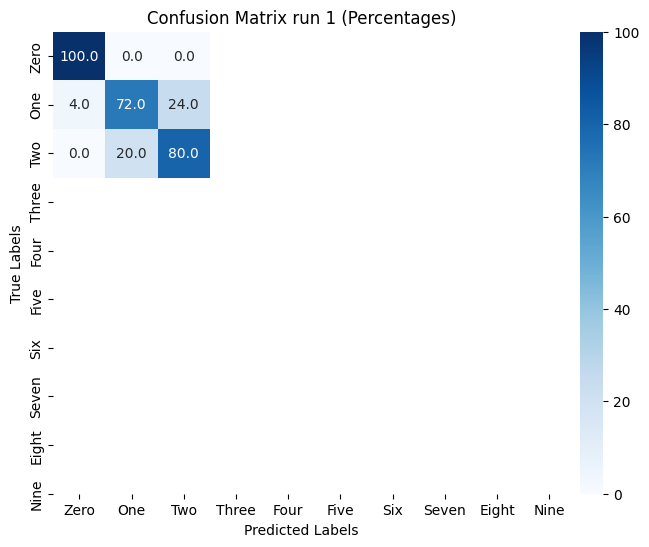

In [41]:
#Confusion Matrix
conf_matrix = confusion_matrix(Y_test, tm.predict(X_test))
# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percent = np.nan_to_num(conf_matrix_percent, 0)  # Replace NaNs with 0

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 1 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [42]:
#Patch object
from matplotlib.gridspec import GridSpec

class Patch:
    def __init__(self, xMin, xMax, yMin, yMax, ID, patch_info, raw, weight=None):
        # Coordinates where patch appears
        self.xMin = xMin
        self.xMax = xMax
        self.yMin = yMin
        self.yMax = yMax
        
        self.weight = weight
        self.ID = ID
        self.patch_info = patch_info # color info in 3x3px 3xcolor uint8
        self.raw = raw #bool vals of whole clause
        self.found_in_images = {}
        self.total_count = 0
        self.sparsity = 0
            
    def visualize_patch_info(self, polarity=0):
        # Rescale the channel values to the range of 0-255
        patch_info_scaled = (np.array(self.patch_info) * (255 / resolution)).astype(np.uint8)
        
        # Create an empty image canvas
        image = np.zeros((3, 3, 3), dtype=np.uint8)
        # Loop through each channel
        for c in range(3):
            image[:,:,c] = patch_info_scaled[:,:,c, polarity].reshape((3,3))
        
        return image
    def dominant_color(self, value=0):
        # Reshape the patch to a 9x3 array
        pixels = self.patch_info[...,0].reshape((9, 3))

        # Calculate the sum of color values for each channel
        color_sums = np.sum(pixels, axis=0)

        # Find the index of the channel with the highest sum
        dominant_channel = np.argmax(color_sums)

        # Determine the dominant color based on the channel index
        if dominant_channel == 0:
            dominant_color = 'R'
        elif dominant_channel == 1:
            dominant_color = 'G'
        else:
            dominant_color = 'B'
        
        if value == 1:
            return dominant_channel
        elif value == 2:
            return sum(self.patch_info[:,:,dominant_channel]) // 3
        else:
            return dominant_color
        
    def update_patch_count(self, image_id, location):
        if image_id in self.found_in_images:
            self.found_in_images[image_id].append(location)
        else:
            self.found_in_images[image_id] = [location]
        self.total_count += 1
        


def thermometer_to_integer(thermometer_bits, negated = 0):
    value = 0
    thermometer_bits_local = thermometer_bits
    length = len(thermometer_bits_local)
    for bit in range(length):
        if not negated:
            if thermometer_bits_local[bit]:
                value = bit+1
        else:
            if thermometer_bits_local[bit]:
                value = bit
                break
            value = length+1
    return value

bank = tm.transform(X_train) # bank is a (image, clause*class) sized array

def transform_clause_to_patch(block, ID, resolution=8, patch_dim=(3,3), image_size=X_train_org.shape[1:3]):
    auxK = 0
    auxJ = image_size[0] - patch_dim[0] -1
    xMin = thermometer_to_integer(block[auxK:auxJ], negated=0)
    auxK = image_size[0] - patch_dim[0]
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
    yMin = thermometer_to_integer(block[auxK:auxJ], negated=0)
    auxK = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] -1
    xMax = thermometer_to_integer(block[auxK:auxJ], negated=1)
    auxK = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0]
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
    yMax = thermometer_to_integer(block[auxK:auxJ], negated=1)
    
    # Sort out the pixels
    patch_info = np.zeros((3,3,3,2)) 
    for column in range(patch_dim[1]):
        # rows = []
        for row in range(patch_dim[0]):
            # colors = []
            for color in range(3):
                auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
                start_bit = auxJ + (column+row) * (3*resolution) + color * resolution
                end_bit = start_bit + resolution
                value = thermometer_to_integer(block[start_bit:end_bit])*(255/resolution)
                
                auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
                start_bit2 = auxJ + (column+row) * (3*resolution) + color * resolution
                end_bit2 = start_bit2 + resolution
                value2 = thermometer_to_integer(block[start_bit2:end_bit2], negated=1)*(255/resolution)
                #value = (value + value2)/2
                #if value == 0: # turn the pixel white if empty
                #    value = 8
                patch_info[column,row,color,0] = value
                patch_info[column,row,color,1] = value2
                # colors.append(value)
            # rows.append(colors)
        # patch_info.append(rows)
    raw = block
    weight = 0
    ID = ID
    return Patch(xMin=xMin, xMax=xMax, yMin=yMin, yMax=yMax, weight=weight, ID=ID, patch_info=patch_info, raw=raw)



Highlighting for image 3 of class Zero
Class 0 Zero
Pro clauses for Class 0: [0, 1, 4]
Against clauses for Class 0: [8]


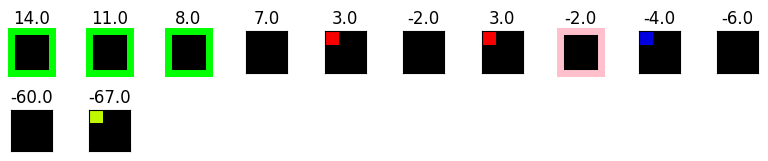

Class 1 One
Pro clauses for Class 1: [0, 1, 4, 13]
Against clauses for Class 1: [8, 15, 18]


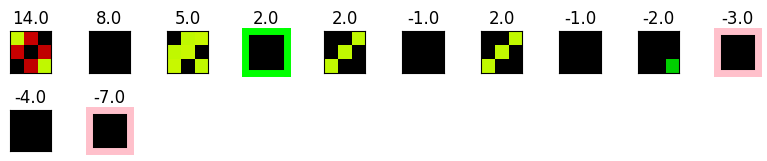

Class 2 Two
Pro clauses for Class 2: [0, 1, 4, 13]
Against clauses for Class 2: [8, 15, 18, 25, 26, 27, 29]


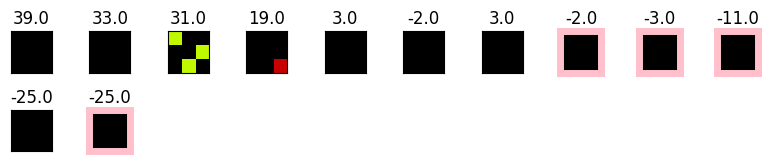

In [43]:
#Weighted Patches list, find extreme patches and plot them

#show how many patches
n_extreme_patches = 6
highlight_colors = {
    "for": "lime",
    "against": "pink"
}

highlight = True
check_image = 3

print("Highlighting for image", check_image, "of class", labels[Y_train_org[check_image]])

pro_clauses = []
against_clauses = []
all_patches = [] #class, clause

# Populate the patches list
k=0 # ID
for Class in range(tm.number_of_classes):
    class_patches = []
    for Clause in range(tm.number_of_clauses):
        block = [tm.get_ta_action(Clause, bit, Class) for bit in range(576)]
        class_patches.append(transform_clause_to_patch(block, k))
        k += 1
    all_patches.append(class_patches)

# Select top clauses
highest_indices = np.zeros((tm.number_of_classes, n_extreme_patches))
lowest_indices  = np.zeros((tm.number_of_classes, n_extreme_patches))
weights_sorted_indices = np.zeros((tm.number_of_classes, tm.number_of_clauses))
all_weights = np.zeros((tm.number_of_classes, tm.number_of_clauses))

for Class in range(tm.number_of_classes):
    for clause in range(tm.number_of_clauses):
        all_weights[Class, clause] = (tm.get_weight(the_class=Class,clause=clause,polarity=0))
    weights_sorted_indices[Class] = all_weights[Class].argsort()
    highest_indices[Class] = weights_sorted_indices[Class][-n_extreme_patches:].astype(int)
    lowest_indices[Class]  = weights_sorted_indices[Class][:n_extreme_patches].astype(int)

# Assign lowest and highest weighted patches to the indices  
extreme_patches = np.zeros((tm.number_of_classes,2,n_extreme_patches), dtype=Patch)
extreme_weights = np.zeros((tm.number_of_classes,2,n_extreme_patches), dtype=np.int16)
    
for Class in range(tm.number_of_classes):
    print("Class", Class, labels[Class])
    polarity = 0
    for i, k in enumerate(lowest_indices[Class].astype(int)):
        all_patches[Class][np.min((k, 997))].weight = all_weights[Class][np.min((k, 997))]
        extreme_patches[Class, polarity, i] = all_patches[Class][np.min((k, 997))]
        
    polarity = 1
    for i, k in enumerate(highest_indices[Class].astype(int)):
        all_patches[Class][k].weight = all_weights[Class][k]
        extreme_patches[Class, polarity, i] = all_patches[Class][k]


    extreme_patches = np.flip(extreme_patches,2)
    
    # Assign Pro and Against clauses per class
    for clause in range(int(tm.number_of_clauses/2)):  # First half for pro_clauses
        if bank[check_image][clause + Class * tm.number_of_clauses]:  # If the clause is activated
            pro_clauses.append(clause + Class * tm.number_of_clauses)
    for clause in range(int(tm.number_of_clauses/2), tm.number_of_clauses):  # Second half for against_clauses
        if bank[check_image][clause + Class * tm.number_of_clauses]:  # If the clause is activated
            against_clauses.append(clause + Class * tm.number_of_clauses)
    print(f"Pro clauses for Class {Class}: {pro_clauses}")
    print(f"Against clauses for Class {Class}: {against_clauses}")



    #Print patches grid
    num_rows = 10
    num_cols = 10

    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(num_rows, num_cols)
    adjusted_index = 0
    for patch_index in range(0, n_extreme_patches*2):
        if (patch_index >= n_extreme_patches): 
            polarity = 0
            adjusted_index = patch_index - n_extreme_patches
        else:
            adjusted_index = patch_index
            polarity = 1
        ax = fig.add_subplot(gs[patch_index // num_cols, patch_index % num_cols])
        ax.imshow(extreme_patches[Class, polarity, adjusted_index].visualize_patch_info())
        
        if highlight:
            # Highlight the randomly selected patches
            if polarity == 1 and extreme_patches[Class, polarity, adjusted_index].ID in pro_clauses:
                for spine in ax.spines.values():
                    spine.set_edgecolor(highlight_colors["for"])
                    spine.set_linewidth(5)
            elif polarity == 0 and extreme_patches[Class, polarity, adjusted_index].ID in against_clauses:
                for spine in ax.spines.values():
                    spine.set_edgecolor(highlight_colors["against"])
                    spine.set_linewidth(5)
            
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
        ax.set_title((extreme_weights[Class][polarity][adjusted_index]).astype(str) + " " + (extreme_patches[Class, polarity, adjusted_index]).dominant_color())
        ax.set_title(extreme_patches[Class, polarity, adjusted_index].weight.astype(str))

    
    plt.tight_layout()
    plt.show()

In [44]:
def find_patches_in_image(image, patches_to_search, targeted_search=False, avg=True):
    """
    Search for specific patches within a given image. Return found ID and coordinates.
    
    Parameters:
    - image: 2D array representing the image.
    - patches_to_search: List of Patch objects to search for in the image.
    - targeted_search: Boolean indicating whether to search only within the patch's expected coordinates.
    - avg: Boolean indicating whether to return average coordinates for each patch.
    
    Returns:
    - results: Array with shape (number of patches, 3) containing the patch ID and its (average) x and y coordinates.
    - found_coordinates: List of tuples containing the coordinates where patches were found.
    """
    results = []
    for patch in patches_to_search:
        patch_info = patch.patch_info
        
        # Define the search area based on the targeted_search flag
        if targeted_search:
            search_area = image[patch.xMin:patch.xMax, patch.yMin:patch.yMax]
            offset_x, offset_y = patch.xMin, patch.yMin
        else:
            search_area = image
            offset_x, offset_y = 0, 0
        
        found_coordinates = []
        for x in range(search_area.shape[0] - patch_info.shape[0] + 1):
            for y in range(search_area.shape[1] - patch_info.shape[1] + 1):
                region = search_area[x:x+patch_info.shape[0], y:y+patch_info.shape[1]]
                if np.all(region >= patch_info[...,0]) and np.all(region <= patch_info[...,1]):
                    found_coordinates.append((x + offset_x, y + offset_y))
        
        # Calculate average coordinates if required
        if avg and found_coordinates:
            avg_x = int(np.mean([coord[0] for coord in found_coordinates]))
            avg_y = int(np.mean([coord[1] for coord in found_coordinates]))
            results.append((patch.ID, avg_x, avg_y))
        elif not avg:
            results.append((patch.ID, found_coordinates))
    
    return results


def find_patches_in_images(images, labels, patches_to_find):

    num_images = len(images)
    valid_indices = np.where((labels < patches_to_find.shape[0]) & (labels < num_images))[0]
    
    results = [find_patches_in_image(images[i], patches_to_find[labels[i], 0, :], targeted_search=True) for i in tqdm(valid_indices, desc="Processing images", position=0, leave=True)]
    
    return results  # Return the list of arrays directly


def encode_origin(images, Y_images, origin_points, n_origin_points=2):
    """
    Encode images based on the distance and angle to the origin patch.
    
    Parameters:
    - images: List of 2D arrays representing the images.
    - Y_images: List of labels corresponding to each image.
    - origin_points: List of origin points.
    - n_origin_points: Number of origin points to consider.
    
    Returns:
    - encoded_patches: Array containing the encoded images.
    """
    batch_size, height, width, _ = images.shape
    encoded_patches = np.empty((batch_size, height, width, 2 * n_origin_points))

    for i in range(batch_size):
        class_label = Y_images[i, 0] if len(Y_images.shape) > 1 else Y_images[i] #TODO: sometimes its two dim array??
        if class_label < tm.number_of_classes:
            origins = origin_points[class_label]  # Adjusted to get origins for specific image and class
        else:
            encoded_patches[i] = np.zeros((height, width, 2 * n_origin_points))
            continue
        
        for point in range(n_origin_points):
            origin_coord = origins[i]
            
            # Check if the origin coordinate is a placeholder
            if np.any(origin_coord == -1):
                continue
            for j in range(height):
                for k in range(width):
                    distance, angle = calculate_distance_and_angle(origin_coord, (j, k))
                    encoded_patches[i, j, k, point*2:point*2+2] = [distance, angle]
            
    return encoded_patches


def scale_value_int(value, old_max, new_max):
    return int((value / old_max) * new_max)


def calculate_distance_and_angle(coord1, coord2):
    #TODO: remove the koeficients and replace with variable adjusting. the scaling now is to fit 0 to 255 scale
    distance = 7* math.sqrt((coord2[0] - coord1[0])**2 + (coord2[1] - coord1[1])**2)
    angle = 80 * math.atan2(coord2[1] - coord1[1], coord2[0] - coord1[0])
    return distance, angle



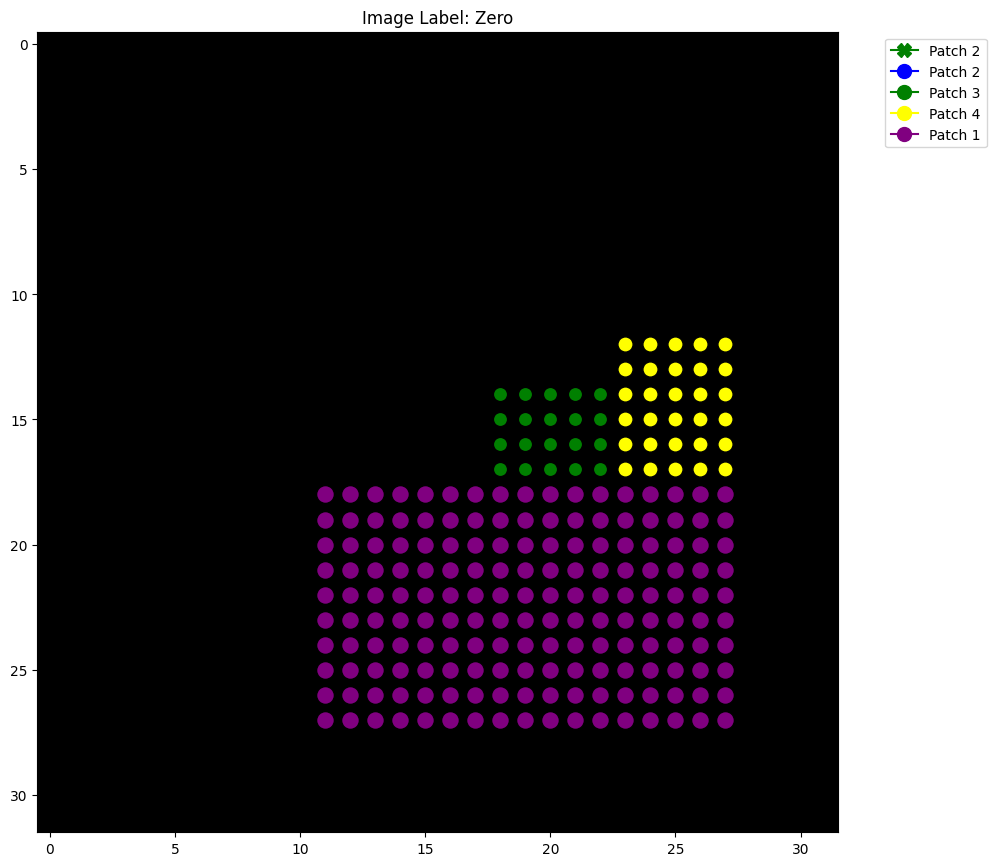

Minimum values of patches


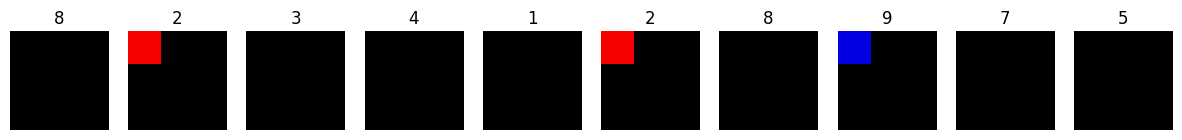

Maximum values of patches


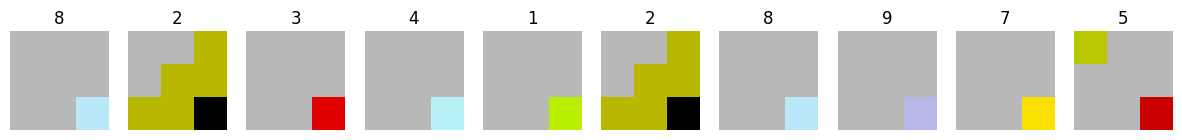

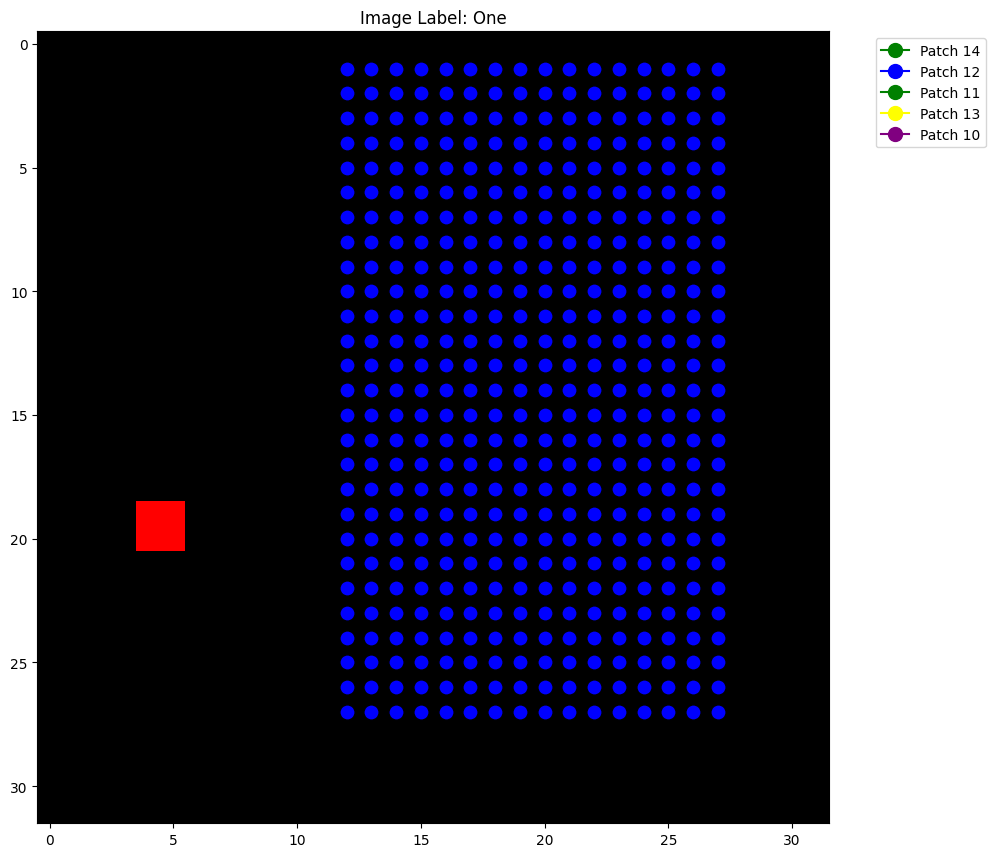

Minimum values of patches


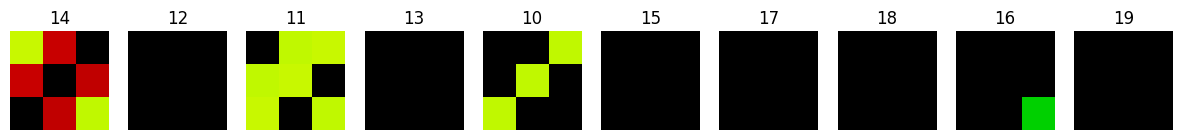

Maximum values of patches


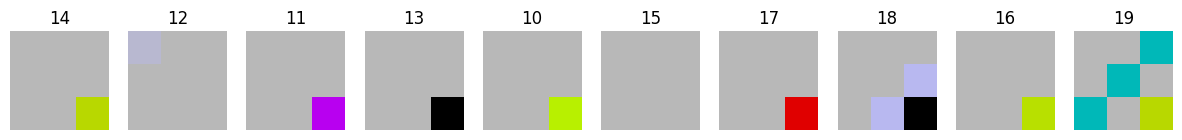

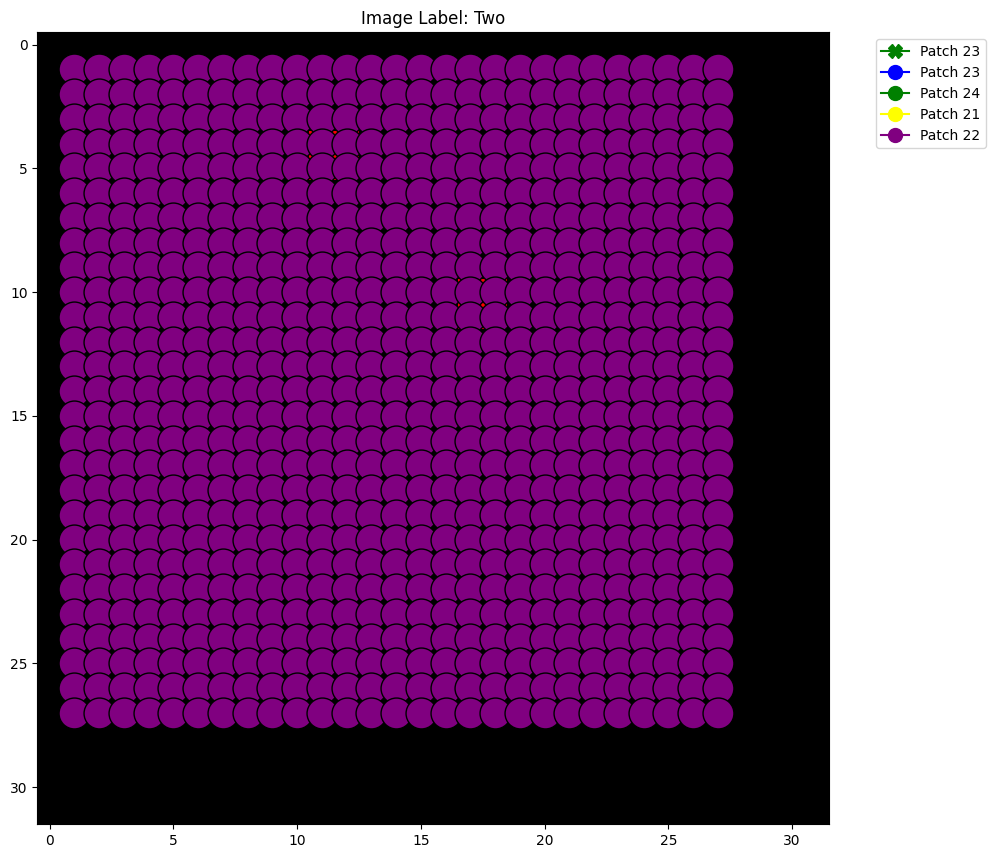

Minimum values of patches


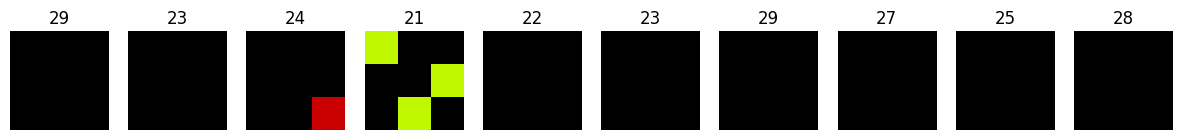

Maximum values of patches


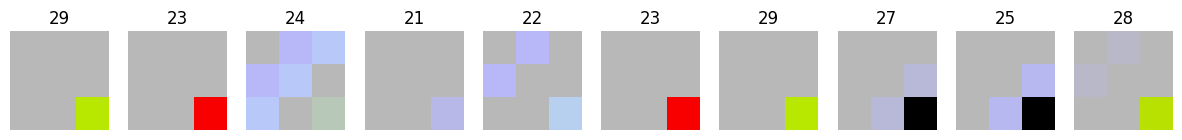

In [45]:
#Plot extreme patches on images

def plot_patches_in_images(patch_list_pos, patch_list_neg, images, image_labels):
    all_results = {}
    
    # Define a list of colors
    colors = ['green', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink']
    
    for img_index, (image, label) in enumerate(zip(images, image_labels)):
        results = []
        legend_elements = []  # List to hold the legend elements
        heatmaps = np.zeros_like(image, dtype=float)

        # Plot the main image with dots
        fig_main, ax_main = plt.subplots(figsize=(10, 10))
        ax_main.imshow(image, cmap='gray')
        ax_main.set_title(f'Image Label: {label}')

        for patch_idx, (patch_pos, patch_neg) in enumerate(zip(patch_list_pos, patch_list_neg)):
            patch = patch_pos if patch_pos.weight > 0 else patch_neg
            marker_style = 'o' if patch_pos.weight > 0 else 'X'
            
            # Use the new find_patches_in_image function
            patch_search_results = find_patches_in_image(image, [patch], targeted_search=True, avg=False)
            
            color = colors[patch_idx % len(colors)]
            for patch_id, patch_coords in patch_search_results:
                for coord in patch_coords:
                    # Plot the position with the chosen marker style
                    ax_main.scatter(coord[1]+1, coord[0]+1, color=color, s=abs(patch.weight*15), marker=marker_style, edgecolors='black', linewidths=1)
                    results.append((patch_id, coord[0], coord[1]))
            
            # Add a legend element for each patch
            legend_elements.append(Line2D([0], [0], marker=marker_style, color=color, label=f'Patch {patch.ID}', markersize=10, markerfacecolor=color, markeredgewidth=1))

        # Add the legend outside of the main plot
        ax_main.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        print("Minimum values of patches")
        # Plot each patch in a separate figure
        fig_patches, axs = plt.subplots(1, len(patch_list_pos) + len(patch_list_neg), figsize=(15, 3))
        if len(patch_list_pos) + len(patch_list_neg) == 1:
            axs = [axs]

        for patch_idx, patch in enumerate(patch_list_pos + patch_list_neg):
            patch_image = patch.visualize_patch_info()  # Visualize the patch
            axs[patch_idx].imshow(patch_image)
            axs[patch_idx].set_title(f'{patch.ID}')
            axs[patch_idx].axis('off')  # Hide the axis

        plt.show()
        print("Maximum values of patches")
        # Plot each patch in a separate figure
        fig_patches, axs = plt.subplots(1, len(patch_list_pos) + len(patch_list_neg), figsize=(15, 3))
        if len(patch_list_pos) + len(patch_list_neg) == 1:
            axs = [axs]

        for patch_idx, patch in enumerate(patch_list_pos + patch_list_neg):
            patch_image = patch.visualize_patch_info(polarity=1)  # Visualize the patch
            axs[patch_idx].imshow(patch_image)
            axs[patch_idx].set_title(f'{patch.ID}')
            #axs[patch_idx].set_title(f'{patch.weight}')
            axs[patch_idx].axis('off')  # Hide the axis
 
        plt.show()

        all_results[img_index] = results
    
    return all_results




for index, image in enumerate(X_test_org[0:len(trained_labels)]):
    # Example usage: extreme_patches[Class, polarity, adjusted_index]
    patches_to_search_pos = [extreme_patches[Y_test_org[index]][1][n_extreme_patches-k-1] for k in range(5)]
    patches_to_search_neg = [extreme_patches[Y_test_org[index]][0][k] for k in range(5)]
    show_results = plot_patches_in_images(patches_to_search_pos, patches_to_search_neg, [image], [labels[Y_test_org[index]]])

In [46]:
print("Finding patches in images...")
X_test_all_results = find_patches_in_images(X_test_org, Y_test_org, extreme_patches)
X_train_all_results = find_patches_in_images(X_train_org, Y_train_org, extreme_patches)

Finding patches in images...


Processing images: 100%|██████████| 1000/1000 [00:04<00:00, 206.57it/s]


In [47]:
#find anchors on test data
counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
for image_results in X_test_all_results:
    for patch in image_results:
        patch_id = patch[0]
        counts[patch_id] += 1

# Initialize origin_points
origin_points = [[] for _ in range(tm.number_of_classes)]
# Get anchor points for each class
for Class in range(tm.number_of_classes):
    # Sort per class, args are IDs, get two most common
    anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:]
    #IDs now per class
    for anchor_id in anchor_ids: #per ID
        # Find the coordinates of the anchor patches
        for image_results in X_test_all_results: 
            for result in image_results:
                if result[0] == anchor_id:
                    origin_points[Class].append(result[1:])  # Assuming result[1] has the coordinates
                else:
                    origin_points[Class].append([0,0]) 

# Now pass this to the encode_origin function
encoded_patches_test = encode_origin(X_test_org, Y_test_org, origin_points, 2)


In [48]:
#find anchors on train data
counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
for image_results in X_train_all_results:
    for patch in image_results:
        patch_id = patch[0]
        counts[patch_id] += 1
anchors_id = []

# Initialize origin_points
origin_points = [[] for _ in range(tm.number_of_classes)]
# Get anchor points for each class
for Class in range(tm.number_of_classes):
    # Sort per class, args are IDs, get two most common
    anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:]
    #IDs now per class
    for anchor_id in anchor_ids: #per ID
        # Find the coordinates of the anchor patches
        for image_results in X_test_all_results: 
            for result in image_results:
                if result[0] == anchor_id:
                    origin_points[Class].append(result[1:])  # Assuming result[1] has the coordinates
                else:
                    origin_points[Class].append([0,0]) 

# Now pass this to the encode_origin function
encoded_patches_train = encode_origin(X_train_org, Y_train_org, origin_points, 2)


In [49]:

# Create the windowed datasets
X_train, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_train_org), thermometer_encode(encoded_patches_train), patch_dim=patch_dim)
X_test,  dataset_dimensions = create_windowed_dataset(thermometer_encode(X_test_org), thermometer_encode(encoded_patches_test), patch_dim=patch_dim)



In [50]:
#Train the TM and record results
#f = open("run_%.1f_%d_%d_%d_%d_%d.txt" % (s, clauses, T, step, visual_tokens), "w+")
logTrain = np.zeros((epochs, X_train.shape[0]), dtype=np.uint8)
logTest =  np.zeros((epochs, X_test.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest[epoch] = (tm.predict(X_test))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train) == Y_train).mean()
                logTrain[epoch] = (tm.predict(X_train))*label

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                #print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                #f.flush()
#f.close()



Training:
3 labels used: [0 1 2]
Training pictures: 1000
Testing:
3 labels used: [0 1 2]
Maximum achievable accuracy: 100.0
..adjusting
Testing pictures: 300

Accuracy over 5 epochs:



  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-12 10:56:57,829 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 20%|██        | 1/5 [00:12<00:51, 12.91s/it]

0 0 72.33 70.80 2.50 2.25


 40%|████      | 2/5 [00:23<00:34, 11.60s/it]

0 1 74.67 73.80 0.29 2.25


 60%|██████    | 3/5 [00:34<00:22, 11.09s/it]

0 2 75.00 75.00 0.23 2.25


 80%|████████  | 4/5 [00:44<00:10, 10.88s/it]

0 3 73.33 74.10 0.24 2.25


100%|██████████| 5/5 [00:55<00:00, 11.13s/it]


0 4 78.33 75.90 0.28 2.39

Accuracy over 5 epochs:



  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-12 10:57:53,502 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 20%|██        | 1/5 [00:11<00:47, 11.91s/it]

1 0 71.67 74.20 1.76 2.28


 40%|████      | 2/5 [00:22<00:33, 11.16s/it]

1 1 71.00 71.90 0.29 2.25


 60%|██████    | 3/5 [00:33<00:21, 10.87s/it]

1 2 75.00 74.80 0.22 2.25


 80%|████████  | 4/5 [00:43<00:10, 10.71s/it]

1 3 82.33 83.00 0.23 2.25


100%|██████████| 5/5 [00:54<00:00, 10.80s/it]


1 4 86.33 83.60 0.26 2.25

Accuracy over 5 epochs:



  0%|          | 0/5 [00:00<?, ?it/s]

2023-12-12 10:58:47,533 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


 20%|██        | 1/5 [00:11<00:47, 11.84s/it]

2 0 77.00 75.40 1.65 2.22


 40%|████      | 2/5 [00:22<00:33, 11.03s/it]

2 1 82.67 79.80 0.27 2.23


 60%|██████    | 3/5 [00:32<00:21, 10.78s/it]

2 2 68.00 68.00 0.21 2.26


 80%|████████  | 4/5 [00:43<00:10, 10.63s/it]

2 3 80.33 79.30 0.20 2.25


100%|██████████| 5/5 [00:53<00:00, 10.71s/it]

2 4 75.00 75.10 0.24 2.24


2023-12-12 10:59:42,506 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x30e0ab940>


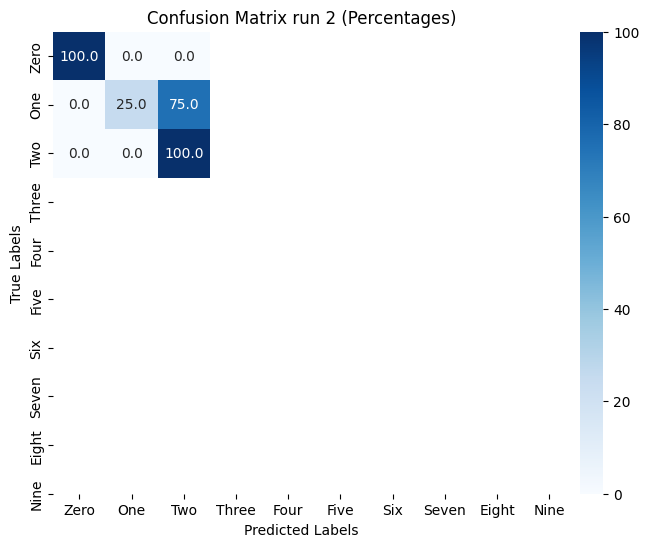

In [51]:
#Confusion Matrix
conf_matrix = confusion_matrix(Y_test, tm.predict(X_test))
# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percent = np.nan_to_num(conf_matrix_percent, 0)  # Replace NaNs with 0

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 2 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
